In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.autograd import Variable
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy
import pickle
from tqdm import tqdm
from sklearn.metrics import confusion_matrix

###### Load Dataset usign torchvision image loader

In [2]:
#Define transforms for the training data and testing data
train_transforms = transforms.Compose([transforms.RandomRotation(30),
                                       transforms.Resize(256),
                                       transforms.RandomResizedCrop(224),
                                       transforms.RandomHorizontalFlip(),
                                       transforms.ToTensor(),
                                       transforms.Normalize([0.485, 0.456, 0.406],
                                                            [0.229, 0.224, 0.225])])

test_transforms = transforms.Compose([transforms.Resize(256),
                                      transforms.CenterCrop(224),
                                      transforms.ToTensor(),
                                      transforms.Normalize([0.485, 0.456, 0.406],
                                                           [0.229, 0.224, 0.225])])

#pass transform here-in
train_data = datasets.ImageFolder('Task 1/train', transform=train_transforms)
test_data = datasets.ImageFolder('Task 1/test', transform=test_transforms)
valid_data = datasets.ImageFolder('Task 1/validation', transform=test_transforms)


#data loaders
trainloader = torch.utils.data.DataLoader(train_data, batch_size=8, shuffle=True)
testloader = torch.utils.data.DataLoader(test_data, batch_size=8, shuffle=True)

print("Classes: ")
class_names = train_data.classes
print(class_names)

Classes: 
['infected', 'normal']


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


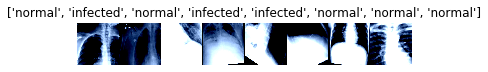

In [3]:

def imshow(inp, title=None):
    inp = inp.numpy().transpose((1, 2, 0))
    plt.axis('off')
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)

def show_databatch(inputs, classes):
    out = torchvision.utils.make_grid(inputs)
    imshow(out, title=[class_names[x] for x in classes])

# Get a batch of training data
inputs, classes = next(iter(trainloader))
show_databatch(inputs, classes)

###### Creating Wrapper Model

In [4]:
class Trained_ClassifierModel:
    def __init__(self, model):
        self.model = model
        self.predicted_out = list()
        
 
    
    def freez_layers(self, freezLayers, model):
        # input values
        # 'all' to freez all layers
        # 'none' to unfreez all layers
        # integer value to freez n layers
        
        # to freez all Layers
        if type (freezLayers) == type ('str') and freezLayers == 'all':
            if model == 'vgg16':
                for param in self.model.features.parameters():
                    param.require_grad = False
            elif model == 'resnet18':
                for param in self.model.parameters():
                    param.require_grad = False
            
            print ("Layers freezed = ALL" )
         
        elif type (freezLayers) == type ('str') and freezLayers == 'none':
            print ("Layers freezed = NONE")
        
        # pass integer freezLayers = 2 it will keep last 2 layers unfreezed
        # and will freez reset of the layers
        # if there are n layers and input is m then n-m layers will be freezed
        # and m layers will be unfreezed
        elif type (freezLayers) !=type ('str'):   
            size = 0
            index = 0
            
            # no_of_unfreezing_layers = 0   freez all layers
            # no_of_unfreezing_layers = n   freez layers upto n
            if model == 'vgg16':
                for param in self.model.features.parameters():
                    size = size + 1
                no_of_unfreezing_layers = size - freezLayers 
            
                for param in self.model.features.parameters():
                    if index < no_of_unfreezing_layers:
                        param.require_grad = False
#                         print('Freezing Layer '+str(index+1))
                        
                    index = index+1
            
            elif model == 'resnet18':
                for param in self.model.parameters():
                    size = size + 1
                no_of_unfreezing_layers = size - freezLayers 
            
                for param in self.model.parameters():
                    if index < no_of_unfreezing_layers:
                        param.require_grad = False
#                         print('Freezing Layer '+str(index+1))
                        
                    index = index+1
                    
            print ("Layers freezed = ", freezLayers)
            
                
    def get_classifier_in_features(self, modelName):
        if modelName == 'resnet18':
            return self.model.fc.in_features
        else :
            return self.model.classifier[0].in_features
        
        
        
    def replacelayers(self, fc):
        features = fc
        # remove all FC Layers and  replace it with our FC layers
        self.model.classifier = nn.Sequential(*features)
        return self.model
    
       
    def getModel(self):
        return self.model
    
    def setModel(model):
        self.model = model
        
    def calculateF1(self, cm):
        TP = np.diag(cm)
        FP = np.sum(cm, axis= 0 ) - TP
        FN = np.sum(cm, axis = 1) - TP
        precision = TP/(TP+FP)
        recall = TP/(TP+FN)
        F1 = (2*(precision*recall))/(precision+recall)
        return F1
    
    def train(self, trainloader, valid_loader,optimizer, Epochs, criterion, device, model_name):
        print ("**********************  TRAINING  ******************************")
        
        #if you have gpu then you need to convert the network and data to cuda
        #the easiest way is to first check for device and then convert network and data to device
        if torch.cuda.is_available():
            print ('running on GPU')
        else:
            print('running on CPU')
         
                
        self.model.to(device)

        self.model.train()
        loss_list = list()
        accuracy_list = list()
        
        
        for epoch in range(Epochs):  # loop over the dataset multiple times
            
            true_labels = torch.zeros(0, dtype = torch.long , device = device)
            pred_labels = torch.zeros(0, dtype = torch.long , device = device)
        
            running_loss = 0.0
            pbar = tqdm(enumerate(trainloader))
            for i, data in pbar:
                # get the inputs
                inputs, labels = data
                inputs, labels = inputs.to(device), labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()
                # In PyTorch, we need to set the gradients to zero before starting to do backpropragation 
                # because PyTorch accumulates the gradients on subsequent backward passes. 
                # This is convenient while training RNNs. 
                # So, the default action is to accumulate the gradients on every loss.backward() call


                # forward + backward + optimize
                outputs = self.model(inputs)               #----> forward pass
                _, predicted = torch.max(outputs.data, 1)
                loss = criterion(outputs, labels)   #----> compute loss
                loss.backward()                     #----> backward pass
                optimizer.step()                    #----> weights update

                
                # print statistics
                running_loss += loss.item()
                
                pred_labels = torch.cat([pred_labels, predicted.view(-1)])
                true_labels = torch.cat([true_labels, labels.view(-1)])
                
                pbar.set_description(
                    'Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                        epoch, i * len(inputs), len(trainloader.dataset),
                        100. * i / len(trainloader),
                        loss.item()))
            
            loss_list.append(running_loss)
            torch.save(self.model.state_dict(), model_name)
            print('Training epoch '+ str(epoch) +' confusion matrix')
            cm = confusion_matrix(true_labels.cpu().numpy(), pred_labels.cpu().numpy())
            print (cm)
            
         
            
        
        plt.plot(range(0,len(loss_list)), loss_list, "r", label = model_name + " - Training Loss curve") 
        plt.xlabel("epochs")
        plt.ylabel("Error")
        plt.legend()
        plt.show()
        
        accuracy_list = self.test(valid_loader, device, test_label = "Valid")
        
        plt.plot(range(0,len(accuracy_list)), accuracy_list, "r", label = model_name + " - Valid accuracy curve") 
        plt.xlabel("epochs")
        plt.ylabel("accuracy")
        plt.legend()
        plt.show()
        
        print ("********************** END TRAINING  ******************************")
        
    def test(self, testloader, device, test_label = "test"):
        
        print ("**********************  "+test_label+"  ******************************")
        dataiter = iter(testloader)
        images, labels = dataiter.next()
        print (test_label+" data batch sample")
        show_databatch(images, labels)
        
        images, labels = images.to(device), labels.to(device) #-->convert test image to cuda (if available)
        outputs = self.model(images)                               #--> forward pass
        _, predicted = torch.max(outputs, 1)

        print('Predicted: ', ' '.join('%5s' % class_names[predicted[j]]
                                      for j in range(len(images))))
        print('Ground Truth: ', ' '.join('%5s' % class_names[labels[j]]
                                      for j in range(len(images))))
        correct = 0
        total = 0
        true_labels = torch.zeros(0, dtype = torch.long , device = device)
        pred_labels = torch.zeros(0, dtype = torch.long , device = device)
        accuracy_list = list()
        
        with torch.no_grad():
            loss_list = list()
            for data in testloader:
                images, labels = data
                images, labels = images.to(device), labels.to(device)
                outputs = self.model(images)
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
                accuracy_list.append(100* ((predicted == labels).sum().item())/labels.size(0))
                self.predicted_out.append(outputs.cpu().numpy())
                
                pred_labels = torch.cat([pred_labels, predicted.view(-1)])
                true_labels = torch.cat([true_labels, labels.view(-1)])
                
#                 loss = criterion(outputs, labels)   #----> compute loss
#                 loss_item.append(loss.item())
                
       
        
        
        
        print(test_label +' matrix')
        cm = confusion_matrix(true_labels.cpu().numpy(), pred_labels.cpu().numpy())
        print (cm)
        
        print('Accuracy of the network on the 10000 '+test_label+' images: %d %%' % (
            100 * correct / total))
        
        if test_label == "test":
              print ("F1 Mearuser Value = ", self.calculateF1(cm))
#         self.predicted_out = [a.squeeze().tolist() for a in self.predicted_out]
        
        print ("********************** END "+test_label+"  ******************************")
        return accuracy_list

##### Task 1-- VGG28 Test 1

Layers freezed = ALL
[Linear(in_features=25088, out_features=680, bias=True), Linear(in_features=680, out_features=2, bias=True)]
before Replaces FCs VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 2

Train Epoch: 0 [398/1594 (100%)]	Loss: 0.368796: : 200it [05:09,  1.55s/it]


Training epoch 0 confusion matrix
[[562 190]
 [180 662]]


Train Epoch: 1 [398/1594 (100%)]	Loss: 0.256097: : 200it [04:59,  1.50s/it]


Training epoch 1 confusion matrix
[[615 137]
 [110 732]]


Train Epoch: 2 [398/1594 (100%)]	Loss: 0.126613: : 200it [05:00,  1.50s/it]


Training epoch 2 confusion matrix
[[622 130]
 [ 82 760]]


Train Epoch: 3 [398/1594 (100%)]	Loss: 0.406717: : 200it [04:58,  1.49s/it]


Training epoch 3 confusion matrix
[[636 116]
 [ 78 764]]


Train Epoch: 4 [398/1594 (100%)]	Loss: 0.628514: : 200it [04:58,  1.49s/it]


Training epoch 4 confusion matrix
[[632 120]
 [ 74 768]]


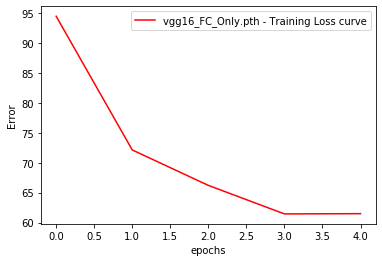

**********************  Valid  ******************************
Valid data batch sample


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


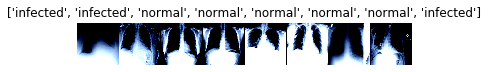

Predicted:  infected infected normal normal normal normal normal infected
Ground Truth:  infected infected normal normal normal normal normal infected
Valid matrix
[[572  43]
 [ 96 608]]
Accuracy of the network on the 10000 Valid images: 89 %
********************** END Valid  ******************************


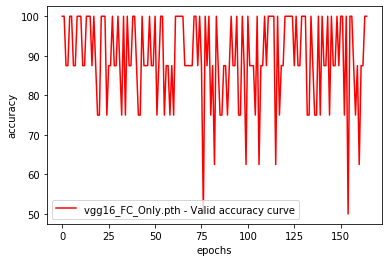

********************** END TRAINING  ******************************
**********************  test  ******************************
test data batch sample


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


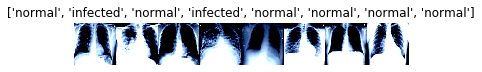

Predicted:  normal infected normal infected normal normal normal normal
Ground Truth:  normal infected normal infected normal normal normal normal
test matrix
[[593  22]
 [ 38 769]]
Accuracy of the network on the 10000 test images: 95 %
F1 Mearuser Value =  [0.95184591 0.96245307]
********************** END test  ******************************


In [6]:

vgg16_d = models.vgg16(pretrained=True)


Epochs = 5
criterion = nn.CrossEntropyLoss()
features = list()
model_name = "vgg16_FC_Only.pth"

#############################  batch size  = 8        ##############################
batch_size = 8
#############################  Learning Rate  = 0.001   ##############################
learning_rate = 0.001
#############################  Freezed Layer  = all       ##############################
freez_layers = 'all'

#data loaders
trainloader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, shuffle=True)
testloader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, shuffle=True)
validloader = torch.utils.data.DataLoader(valid_data, batch_size=batch_size, shuffle=True)

############################# Initializing Model ####################################
model = Trained_ClassifierModel(vgg16_d)

############################# Freezing Layer ########################################
model.freez_layers(freez_layers,'vgg16')

#################### getting last layer input features ##############################
num_features = model.get_classifier_in_features('vgg16')

####################### Creating Classification Layers ##############################

# Adding Second Last layer whose no. of neurons will be (58 * 10) + 100 as my Rollno is MSDS 19058
features.extend([nn.Linear(num_features, 680 )])
# Adding last layer with 2 neurons as there 2 classes to classify
features.extend([nn.Linear(680, len(class_names))])
print (features)


####################### Replacing Classification Layers #############################
print ("before Replaces FCs", model.getModel())
model.replacelayers(features)
print ("before Replaces FCs", model.getModel())


####################### Checking Is Cuda available #################################
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

####################### Creating Optimizers #################################
optimizer = optim.SGD(model.getModel().parameters(), learning_rate, 0.9)

############################## Training Model ######################################
model.train(trainloader,validloader, optimizer, Epochs, criterion, device, model_name)


############################### Testing Model ######################################
model.test(testloader, device)


############################## Saving Model  #######################################
pickle.dump(model.getModel, open('vgg16_FC_Only.pth', 'wb'))

#############################Clear Torch Cache ####################################
torch.cuda.empty_cache()

##### Task 1-- VGG16 Test 2

Layers freezed = ALL
[Linear(in_features=25088, out_features=680, bias=True), Linear(in_features=680, out_features=2, bias=True)]
before Replaces FCs VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 2

Train Epoch: 0 [1106/1594 (99%)]	Loss: 0.199933: : 80it [03:52,  2.91s/it]


Training epoch 0 confusion matrix
[[566 186]
 [165 677]]


Train Epoch: 1 [1106/1594 (99%)]	Loss: 0.483706: : 80it [03:43,  2.79s/it]


Training epoch 1 confusion matrix
[[624 128]
 [123 719]]


Train Epoch: 2 [1106/1594 (99%)]	Loss: 0.286519: : 80it [03:44,  2.81s/it]


Training epoch 2 confusion matrix
[[636 116]
 [103 739]]


Train Epoch: 3 [1106/1594 (99%)]	Loss: 0.132556: : 80it [03:46,  2.83s/it]


Training epoch 3 confusion matrix
[[628 124]
 [102 740]]


Train Epoch: 4 [1106/1594 (99%)]	Loss: 0.175240: : 80it [03:45,  2.82s/it]


Training epoch 4 confusion matrix
[[633 119]
 [ 95 747]]


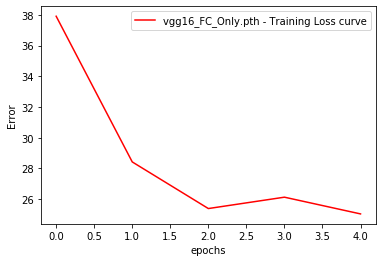

**********************  Valid  ******************************
Valid data batch sample


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


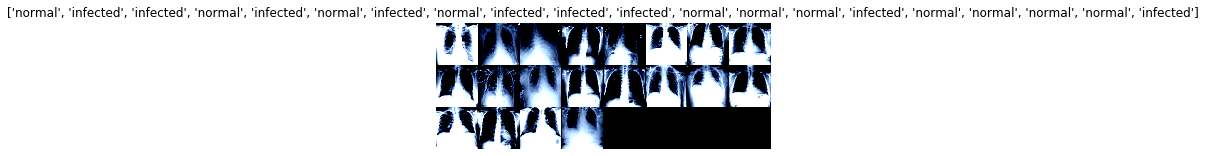

Predicted:  normal infected infected normal infected normal infected normal normal infected infected normal normal normal infected normal normal normal normal infected
Ground Truth:  normal infected infected normal infected normal infected normal infected infected infected normal normal normal infected normal normal normal normal infected
Valid matrix
[[521  94]
 [ 68 636]]
Accuracy of the network on the 10000 Valid images: 87 %
********************** END Valid  ******************************


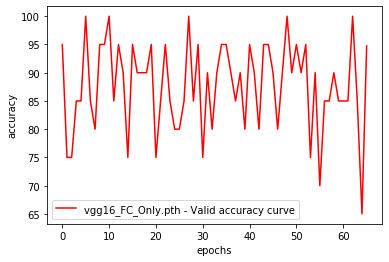

********************** END TRAINING  ******************************
**********************  test  ******************************
test data batch sample


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


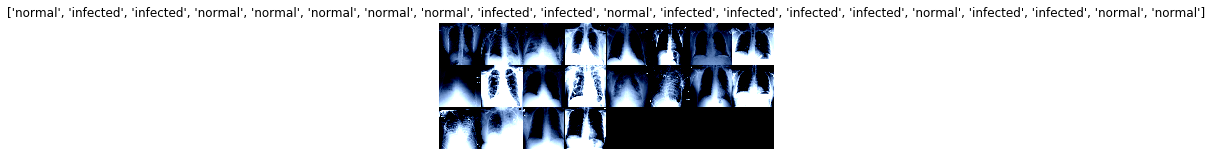

Predicted:  normal infected infected normal infected normal normal normal infected infected normal infected infected infected normal normal infected infected normal normal
Ground Truth:  normal infected infected normal normal normal normal normal infected infected normal infected infected infected infected normal infected infected normal normal
test matrix
[[560  55]
 [ 12 795]]
Accuracy of the network on the 10000 test images: 95 %
F1 Mearuser Value =  [0.94355518 0.95956548]
********************** END test  ******************************


In [5]:

vgg16_d = models.vgg16(pretrained=True)


Epochs = 5
criterion = nn.CrossEntropyLoss()
features = list()
model_name = "vgg16_FC_Only.pth"

#############################  batch size  = 20       ##############################
batch_size = 20
#############################  Learning Rate  = 0.0008   ##############################
learning_rate = 0.0008
#############################  Freezed Layer  = all       ##############################
freez_layers = 'all'

#data loaders
trainloader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, shuffle=True)
testloader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, shuffle=True)
validloader = torch.utils.data.DataLoader(valid_data, batch_size=batch_size, shuffle=True)

############################# Initializing Model ####################################
model = Trained_ClassifierModel(vgg16_d)

############################# Freezing Layer ########################################
model.freez_layers(freez_layers,'vgg16')

#################### getting last layer input features ##############################
num_features = model.get_classifier_in_features('vgg16')

####################### Creating Classification Layers ##############################

# Adding Second Last layer whose no. of neurons will be (58 * 10) + 100 as my Rollno is MSDS 19058
features.extend([nn.Linear(num_features, 680 )])
# Adding last layer with 2 neurons as there 2 classes to classify
features.extend([nn.Linear(680, len(class_names))])
print (features)


####################### Replacing Classification Layers #############################
print ("before Replaces FCs", model.getModel())
model.replacelayers(features)
print ("before Replaces FCs", model.getModel())


####################### Checking Is Cuda available #################################
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

####################### Creating Optimizers #################################
optimizer = optim.SGD(model.getModel().parameters(), learning_rate, 0.9)

############################## Training Model ######################################
model.train(trainloader,validloader, optimizer, Epochs, criterion, device, model_name)


############################### Testing Model ######################################
model.test(testloader, device)


############################## Saving Model #######################################
pickle.dump(model.getModel, open('vgg16_FC_Only.pth', 'wb'))

#############################Clear Torch Cache ####################################
torch.cuda.empty_cache()


##### Task 1-- VGG16 Test 3

Layers freezed = ALL
[Linear(in_features=25088, out_features=680, bias=True), Linear(in_features=680, out_features=2, bias=True)]
before Replaces FCs VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 2

Train Epoch: 0 [1106/1594 (99%)]	Loss: 0.533290: : 80it [03:41,  2.76s/it]


Training epoch 0 confusion matrix
[[564 188]
 [165 677]]


Train Epoch: 1 [1106/1594 (99%)]	Loss: 0.280125: : 80it [03:56,  2.95s/it]


Training epoch 1 confusion matrix
[[621 131]
 [117 725]]


Train Epoch: 2 [1106/1594 (99%)]	Loss: 0.470114: : 80it [03:57,  2.97s/it]


Training epoch 2 confusion matrix
[[633 119]
 [104 738]]


Train Epoch: 3 [1106/1594 (99%)]	Loss: 0.311914: : 80it [03:55,  2.94s/it]


Training epoch 3 confusion matrix
[[642 110]
 [ 81 761]]


Train Epoch: 4 [1106/1594 (99%)]	Loss: 0.267331: : 80it [03:54,  2.93s/it]


Training epoch 4 confusion matrix
[[647 105]
 [ 81 761]]


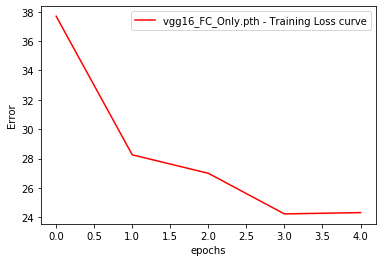

**********************  Valid  ******************************
Valid data batch sample


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


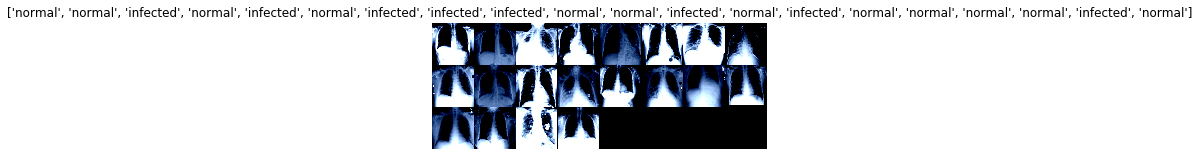

Predicted:  normal normal infected normal infected normal normal infected normal normal normal infected normal infected normal normal normal normal infected normal
Ground Truth:  normal normal infected normal infected normal infected infected infected normal normal infected normal infected normal normal normal normal infected normal
Valid matrix
[[477 138]
 [ 36 668]]
Accuracy of the network on the 10000 Valid images: 86 %
********************** END Valid  ******************************


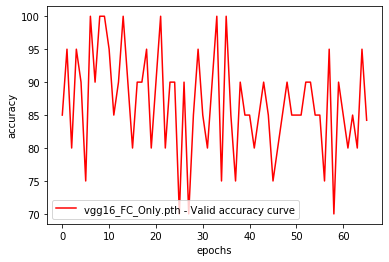

********************** END TRAINING  ******************************
**********************  test  ******************************
test data batch sample


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


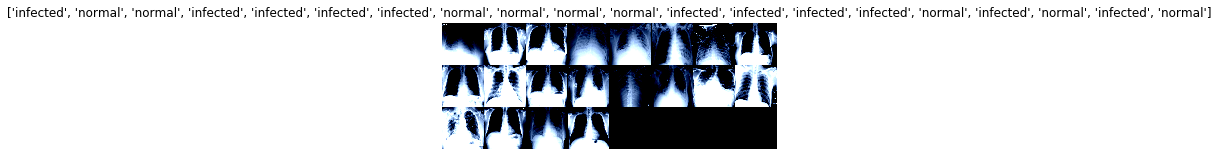

Predicted:  infected normal normal infected infected infected infected normal normal normal normal infected infected infected infected normal infected normal infected normal
Ground Truth:  infected normal normal infected infected infected infected normal normal normal normal infected infected infected infected normal infected normal infected normal
test matrix
[[541  74]
 [ 10 797]]
Accuracy of the network on the 10000 test images: 94 %
F1 Mearuser Value =  [0.92795883 0.94994041]
********************** END test  ******************************


In [5]:
vgg16_d =  models.vgg16(pretrained=True)


Epochs = 5
criterion = nn.CrossEntropyLoss()
features = list()
model_name = "vgg16_FC_Only.pth"

#############################  batch size  = 25        ##############################
batch_size = 25
#############################  Learning Rate  = 0.001   ##############################
learning_rate = 0.001
#############################  Freezed Layer  = all       ##############################
freez_layers = 'all'

#data loaders
trainloader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, shuffle=True)
testloader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, shuffle=True)
validloader = torch.utils.data.DataLoader(valid_data, batch_size=batch_size, shuffle=True)

############################# Initializing Model ####################################
model = Trained_ClassifierModel(vgg16_d)

############################# Freezing Layer ########################################
model.freez_layers(freez_layers,'vgg16')

#################### getting last layer input features ##############################
num_features = model.get_classifier_in_features('vgg16')

####################### Creating Classification Layers ##############################

# Adding Second Last layer whose no. of neurons will be (58 * 10) + 100 as my Rollno is MSDS 19058
features.extend([nn.Linear(num_features, 680 )])
# Adding last layer with 2 neurons as there 2 classes to classify
features.extend([nn.Linear(680, len(class_names))])
print (features)


####################### Replacing Classification Layers #############################
print ("before Replaces FCs", model.getModel())
model.replacelayers(features)
print ("before Replaces FCs", model.getModel())


####################### Checking Is Cuda available #################################
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

####################### Creating Optimizers #################################
optimizer = optim.SGD(model.getModel().parameters(), learning_rate, 0.9)

############################## Training Model ######################################
model.train(trainloader, validloader, optimizer, Epochs, criterion, device, model_name)


############################### Testing Model ######################################
model.test(testloader, device)


############################## Saving Model  #######################################
pickle.dump(model.getModel, open('vgg16_FC_L4.pth', 'wb'))

#############################Clear Torch Cache ####################################
torch.cuda.empty_cache()

##### Task 1-- Resnet Test 1 

Layers freezed = ALL
[Linear(in_features=512, out_features=680, bias=True), Linear(in_features=680, out_features=2, bias=True)]
before Replaces FCs ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=

)
**********************  TRAINING  ******************************
running on GPU


Train Epoch: 0 [398/1594 (100%)]	Loss: 3.196105: : 200it [01:41,  1.97it/s]


Training epoch 0 confusion matrix
[[541 182   0 ...   0   0   0]
 [180 630   1 ...   1   1   1]
 [  0   0   0 ...   0   0   0]
 ...
 [  0   0   0 ...   0   0   0]
 [  0   0   0 ...   0   0   0]
 [  0   0   0 ...   0   0   0]]


Train Epoch: 1 [398/1594 (100%)]	Loss: 0.584944: : 200it [01:40,  1.99it/s]


Training epoch 1 confusion matrix
[[558 194]
 [169 673]]


Train Epoch: 2 [398/1594 (100%)]	Loss: 0.832441: : 200it [01:40,  1.99it/s]


Training epoch 2 confusion matrix
[[588 164]
 [139 703]]


Train Epoch: 3 [398/1594 (100%)]	Loss: 1.414608: : 200it [01:40,  1.99it/s]


Training epoch 3 confusion matrix
[[579 173]
 [178 664]]


Train Epoch: 4 [398/1594 (100%)]	Loss: 0.727864: : 200it [01:40,  1.99it/s]


Training epoch 4 confusion matrix
[[594 158]
 [120 722]]


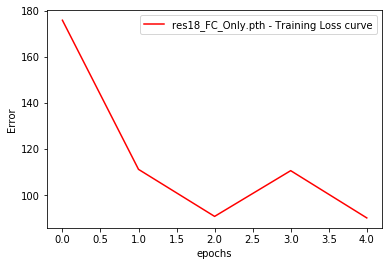

**********************  Valid  ******************************
Valid data batch sample


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


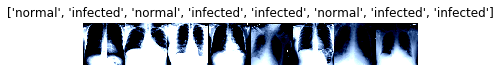

Predicted:  normal normal normal infected infected normal infected normal
Ground Truth:  normal infected normal infected infected normal infected infected
Valid matrix
[[529  86]
 [115 589]]
Accuracy of the network on the 10000 Valid images: 84 %
********************** END Valid  ******************************


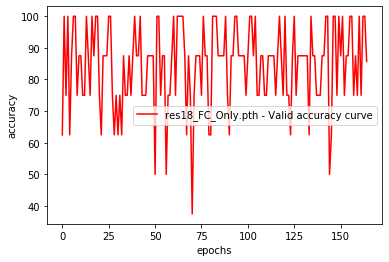

********************** END TRAINING  ******************************
**********************  test  ******************************
test data batch sample


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


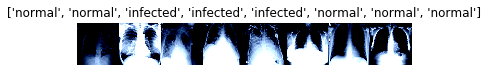

Predicted:  infected normal infected infected infected normal normal normal
Ground Truth:  normal normal infected infected infected normal normal normal
test matrix
[[565  50]
 [111 696]]
Accuracy of the network on the 10000 test images: 88 %
F1 Mearuser Value =  [0.87529047 0.89632968]
********************** END test  ******************************


In [5]:

resnet18_d = models.resnet18(pretrained=True)
Epochs = 5
criterion = nn.CrossEntropyLoss()
features = list()
model_name = "res18_FC_Only.pth"

#############################  batch size  = 8        ##############################
batch_size = 8
#############################  Learning Rate  = 0.001   ##############################
learning_rate = 0.001
#############################  Freezed Layer  = all       ##############################
freez_layers = 'all'

#data loaders
trainloader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, shuffle=True)
testloader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, shuffle=True)
validloader = torch.utils.data.DataLoader(valid_data, batch_size=batch_size, shuffle=True)

############################# Initializing Model ####################################
model = Trained_ClassifierModel(resnet18_d)

############################# Freezing Layer ########################################
model.freez_layers(freez_layers,'resnet18')

#################### getting last layer input features ##############################
num_features = model.get_classifier_in_features('resnet18')

####################### Creating Classification Layers ##############################

# Adding Second Last layer whose no. of neurons will be (58 * 10) + 100 as my Rollno is MSDS 19058
features.extend([nn.Linear(num_features, 680 )])
# Adding last layer with 2 neurons as there 2 classes to classify
features.extend([nn.Linear(680, len(class_names))])
print (features)


####################### Replacing Classification Layers #############################
print ("before Replaces FCs", model.getModel())
model.replacelayers(features)
print ("before Replaces FCs", model.getModel())


####################### Checking Is Cuda available #################################
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

####################### Creating Optimizers #################################
optimizer = optim.SGD(model.getModel().parameters(), learning_rate, 0.9)

############################## Training Model ######################################
model.train(trainloader, validloader, optimizer, Epochs, criterion, device, model_name)



############################### Testing Model ######################################
model.test(testloader, device)


############################## Saving Model #######################################
pickle.dump(model.getModel, open(model_name, 'wb'))


#############################Clear Torch Cache ####################################
torch.cuda.empty_cache()


##### Task 1-- Resnet Test 2

Layers freezed = ALL
[Linear(in_features=512, out_features=680, bias=True), Linear(in_features=680, out_features=2, bias=True)]
before Replaces FCs ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=

)
**********************  TRAINING  ******************************
running on GPU


Train Epoch: 0 [1106/1594 (99%)]	Loss: 0.495418: : 80it [01:29,  1.11s/it]


Training epoch 0 confusion matrix
[[516 149   1 ...   2   1   0]
 [130 623   0 ...   0   0   1]
 [  0   0   0 ...   0   0   0]
 ...
 [  0   0   0 ...   0   0   0]
 [  0   0   0 ...   0   0   0]
 [  0   0   0 ...   0   0   0]]


Train Epoch: 1 [1106/1594 (99%)]	Loss: 0.198992: : 80it [01:29,  1.12s/it]


Training epoch 1 confusion matrix
[[614 138]
 [135 707]]


Train Epoch: 2 [1106/1594 (99%)]	Loss: 0.243244: : 80it [01:29,  1.11s/it]


Training epoch 2 confusion matrix
[[624 128]
 [130 712]]


Train Epoch: 3 [1106/1594 (99%)]	Loss: 0.093822: : 80it [01:28,  1.10s/it]


Training epoch 3 confusion matrix
[[612 140]
 [128 714]]


Train Epoch: 4 [1106/1594 (99%)]	Loss: 0.361677: : 80it [01:28,  1.11s/it]


Training epoch 4 confusion matrix
[[631 121]
 [115 727]]


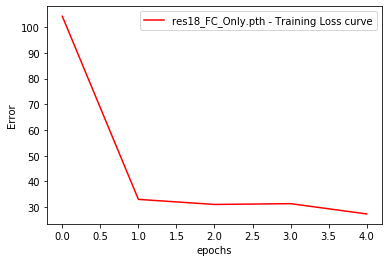

**********************  Valid  ******************************
Valid data batch sample


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


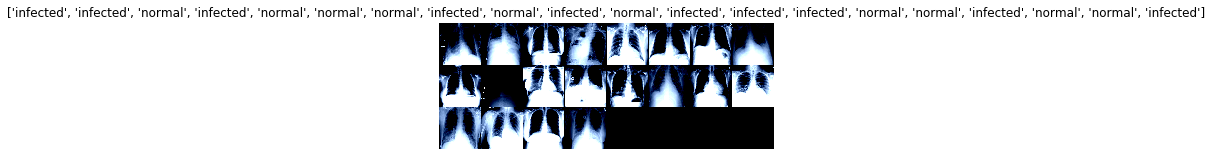

Predicted:  infected infected normal infected normal normal normal infected normal normal normal infected normal infected normal normal infected normal normal infected
Ground Truth:  infected infected normal infected normal normal normal infected normal infected normal infected infected infected normal normal infected normal normal infected
Valid matrix
[[501 114]
 [ 67 637]]
Accuracy of the network on the 10000 Valid images: 86 %
********************** END Valid  ******************************


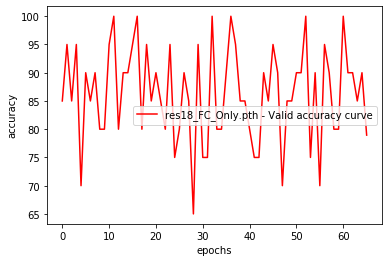

********************** END TRAINING  ******************************
**********************  test  ******************************
test data batch sample


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


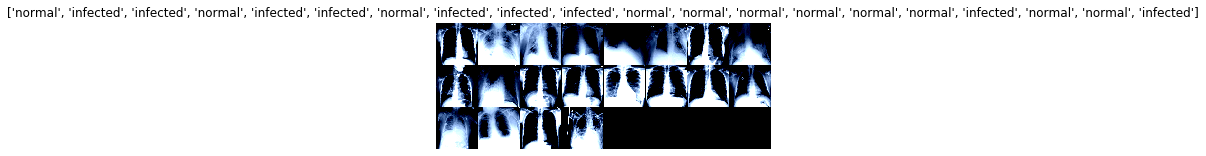

Predicted:  normal infected infected normal infected infected normal infected infected infected normal normal normal normal normal normal infected normal normal infected
Ground Truth:  normal infected infected normal infected infected normal infected infected infected normal normal normal normal normal normal infected normal normal infected
test matrix
[[542  73]
 [ 40 767]]
Accuracy of the network on the 10000 test images: 92 %
F1 Mearuser Value =  [0.90559733 0.93139041]
********************** END test  ******************************


In [7]:

resnet18_d = models.resnet18(pretrained=True)

Epochs = 5
criterion = nn.CrossEntropyLoss()
features = list()
model_name = "res18_FC_Only.pth"

#############################  batch size  = 20        ##############################
batch_size = 20
#############################  Learning Rate  = 0.0008   ##############################
learning_rate = 0.0008
#############################  Freezed Layer  = all       ##############################
freez_layers = 'all'

#data loaders
trainloader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, shuffle=True)
testloader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, shuffle=True)
validloader = torch.utils.data.DataLoader(valid_data, batch_size=batch_size, shuffle=True)

############################# Initializing Model ####################################
model = Trained_ClassifierModel(resnet18_d)

############################# Freezing Layer ########################################
model.freez_layers(freez_layers,'resnet18')

#################### getting last layer input features ##############################
num_features = model.get_classifier_in_features('resnet18')

####################### Creating Classification Layers ##############################

# Adding Second Last layer whose no. of neurons will be (58 * 10) + 100 as my Rollno is MSDS 19058
features.extend([nn.Linear(num_features, 680 )])
# Adding last layer with 2 neurons as there 2 classes to classify
features.extend([nn.Linear(680, len(class_names))])
print (features)


####################### Replacing Classification Layers #############################
print ("before Replaces FCs", model.getModel())
model.replacelayers(features)
print ("before Replaces FCs", model.getModel())


####################### Checking Is Cuda available #################################
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

####################### Creating Optimizers #################################
optimizer = optim.SGD(model.getModel().parameters(), learning_rate, 0.9)

############################## Training Model ######################################
model.train(trainloader, validloader, optimizer, Epochs, criterion, device, model_name)


############################### Testing Model ######################################
model.test(testloader, device)


############################## Saving Model #######################################
pickle.dump(model.getModel, open(model_name, 'wb'))


#############################Clear Torch Cache ####################################
torch.cuda.empty_cache()


##### Task 1-- Resnet Test 3

Layers freezed = ALL
[Linear(in_features=512, out_features=680, bias=True), Linear(in_features=680, out_features=2, bias=True)]
before Replaces FCs ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=

)
**********************  TRAINING  ******************************
running on GPU


Train Epoch: 0 [1197/1594 (98%)]	Loss: 0.393594: : 64it [01:25,  1.34s/it]


Training epoch 0 confusion matrix
[[508 163   0 ...   0   1   0]
 [138 592   1 ...   1   0   1]
 [  0   0   0 ...   0   0   0]
 ...
 [  0   0   0 ...   0   0   0]
 [  0   0   0 ...   0   0   0]
 [  0   0   0 ...   0   0   0]]


Train Epoch: 1 [1197/1594 (98%)]	Loss: 0.700258: : 64it [01:26,  1.35s/it]


Training epoch 1 confusion matrix
[[596 156]
 [129 713]]


Train Epoch: 2 [1197/1594 (98%)]	Loss: 0.800014: : 64it [01:26,  1.35s/it]


Training epoch 2 confusion matrix
[[616 136]
 [113 729]]


Train Epoch: 3 [1197/1594 (98%)]	Loss: 0.399116: : 64it [01:27,  1.36s/it]


Training epoch 3 confusion matrix
[[642 110]
 [121 721]]


Train Epoch: 4 [1197/1594 (98%)]	Loss: 0.764518: : 64it [01:28,  1.38s/it]


Training epoch 4 confusion matrix
[[615 137]
 [111 731]]


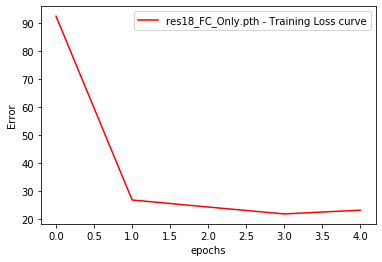

**********************  Valid  ******************************
Valid data batch sample


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


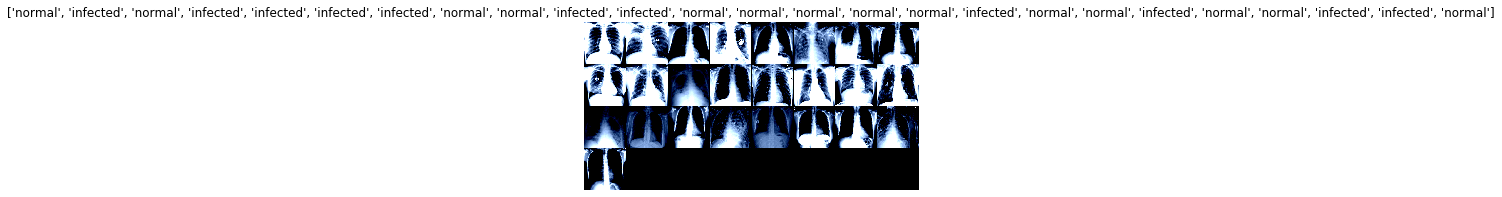

Predicted:  normal normal normal infected infected infected infected normal infected infected infected normal infected normal normal normal infected normal normal infected normal normal infected infected normal
Ground Truth:  normal infected normal infected infected infected infected normal normal infected infected normal normal normal normal normal infected normal normal infected normal normal infected infected normal
Valid matrix
[[500 115]
 [ 63 641]]
Accuracy of the network on the 10000 Valid images: 86 %
********************** END Valid  ******************************


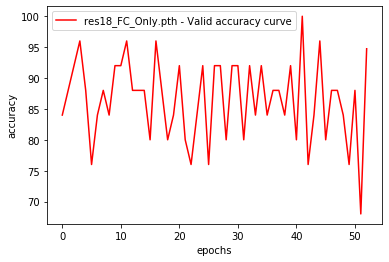

********************** END TRAINING  ******************************
**********************  test  ******************************
test data batch sample


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


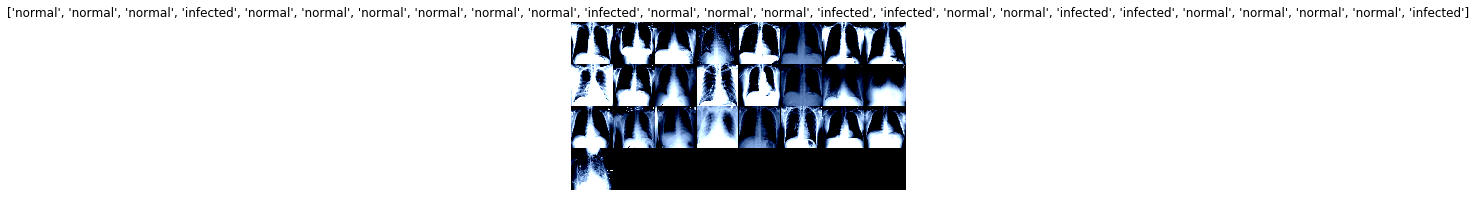

Predicted:  normal normal infected infected normal normal normal normal normal normal infected normal infected normal infected infected normal normal normal infected normal infected normal normal infected
Ground Truth:  normal normal normal infected normal normal normal normal normal normal infected normal normal normal infected infected normal normal infected infected normal normal normal normal infected
test matrix
[[532  83]
 [ 35 772]]
Accuracy of the network on the 10000 test images: 91 %
F1 Mearuser Value =  [0.9001692 0.9290012]
********************** END test  ******************************


In [6]:

resnet18_d = models.resnet18(pretrained=True)

Epochs = 5
criterion = nn.CrossEntropyLoss()
features = list()
model_name = "res18_FC_Only.pth"

#############################  batch size  = 25        ##############################
batch_size = 25
#############################  Learning Rate  = 0.001   ##############################
learning_rate = 0.001
#############################  Freezed Layer  = all       ##############################
freez_layers = 'all'

#data loaders
trainloader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, shuffle=True)
testloader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, shuffle=True)
validloader = torch.utils.data.DataLoader(valid_data, batch_size=batch_size, shuffle=True)

############################# Initializing Model ####################################
model = Trained_ClassifierModel(resnet18_d)

############################# Freezing Layer ########################################
model.freez_layers(freez_layers,'resnet18')

#################### getting last layer input features ##############################
num_features = model.get_classifier_in_features('resnet18')

####################### Creating Classification Layers ##############################

# Adding Second Last layer whose no. of neurons will be (58 * 10) + 100 as my Rollno is MSDS 19058
features.extend([nn.Linear(num_features, 680 )])
# Adding last layer with 2 neurons as there 2 classes to classify
features.extend([nn.Linear(680, len(class_names))])
print (features)


####################### Replacing Classification Layers #############################
print ("before Replaces FCs", model.getModel())
model.replacelayers(features)
print ("before Replaces FCs", model.getModel())


####################### Checking Is Cuda available #################################
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

####################### Creating Optimizers #################################
optimizer = optim.SGD(model.getModel().parameters(), learning_rate, 0.9)

############################## Training Model ######################################
model.train(trainloader, validloader, optimizer, Epochs, criterion, device, model_name)



############################### Testing Model ######################################
model.test(testloader, device)


############################## Saving Model #######################################
pickle.dump(model.getModel, open(model_name, 'wb'))


#############################Clear Torch Cache ####################################
torch.cuda.empty_cache()


# Task 2

##### Task 2- VGG16 - Test 1

Layers freezed =  4
[Linear(in_features=25088, out_features=680, bias=True), Linear(in_features=680, out_features=2, bias=True)]
before Replaces FCs VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 25

Train Epoch: 0 [398/1594 (100%)]	Loss: 0.228029: : 200it [04:36,  1.38s/it]


Training epoch 0 confusion matrix
[[547 205]
 [170 672]]


Train Epoch: 1 [398/1594 (100%)]	Loss: 0.097514: : 200it [04:39,  1.40s/it]


Training epoch 1 confusion matrix
[[613 139]
 [112 730]]


Train Epoch: 2 [398/1594 (100%)]	Loss: 1.535059: : 200it [04:41,  1.41s/it]


Training epoch 2 confusion matrix
[[616 136]
 [111 731]]


Train Epoch: 3 [398/1594 (100%)]	Loss: 0.015297: : 200it [04:44,  1.42s/it]


Training epoch 3 confusion matrix
[[634 118]
 [ 96 746]]


Train Epoch: 4 [398/1594 (100%)]	Loss: 0.083570: : 200it [04:42,  1.41s/it]


Training epoch 4 confusion matrix
[[638 114]
 [ 98 744]]


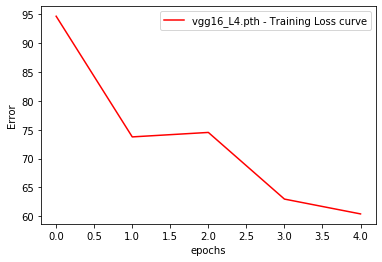

**********************  Valid  ******************************
Valid data batch sample


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


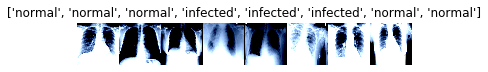

Predicted:  normal normal normal infected normal infected normal infected
Ground Truth:  normal normal normal infected infected infected normal normal
Valid matrix
[[579  36]
 [118 586]]
Accuracy of the network on the 10000 Valid images: 88 %
********************** END Valid  ******************************


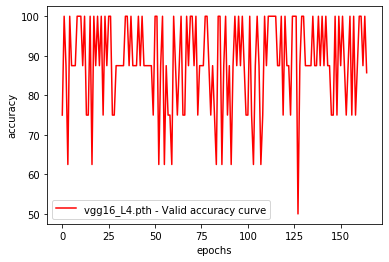

********************** END TRAINING  ******************************
**********************  test  ******************************
test data batch sample


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


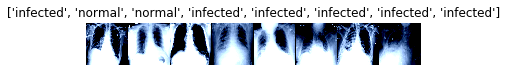

Predicted:  infected infected infected infected infected infected infected infected
Ground Truth:  infected normal normal infected infected infected infected infected
test matrix
[[592  23]
 [ 41 766]]
Accuracy of the network on the 10000 test images: 95 %
F1 Mearuser Value =  [0.94871795 0.95989975]
********************** END test  ******************************


In [5]:
vgg16_d =  models.vgg16(pretrained=True)


Epochs = 5
criterion = nn.CrossEntropyLoss()
features = list()
model_name = "vgg16_L4.pth"

#############################  batch size  = 8        ##############################
batch_size = 8
#############################  Learning Rate  = 0.001   ##############################
learning_rate = 0.001
#############################  Freezed Layer  = 4       ##############################
freez_layers = 4

#data loaders
trainloader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, shuffle=True)
testloader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, shuffle=True)
validloader = torch.utils.data.DataLoader(valid_data, batch_size=batch_size, shuffle=True)

############################# Initializing Model ####################################
model = Trained_ClassifierModel(vgg16_d)

############################# Freezing Layer ########################################
model.freez_layers(freez_layers, 'vgg16')

#################### getting last layer input features ##############################
num_features = model.get_classifier_in_features('vgg16')

####################### Creating Classification Layers ##############################

# Adding Second Last layer whose no. of neurons will be (58 * 10) + 100 as my Rollno is MSDS 19058
features.extend([nn.Linear(num_features, 680 )])
# Adding last layer with 2 neurons as there 2 classes to classify
features.extend([nn.Linear(680, len(class_names))])
print (features)


####################### Replacing Classification Layers #############################
print ("before Replaces FCs", model.getModel())
model.replacelayers(features)
print ("before Replaces FCs", model.getModel())


####################### Checking Is Cuda available #################################
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

####################### Creating Optimizers #################################
optimizer = optim.SGD(model.getModel().parameters(), learning_rate, 0.9)

############################## Training Model ######################################
model.train(trainloader, validloader, optimizer, Epochs, criterion, device, model_name)


############################### Testing Model ######################################
model.test(testloader, device)


############################## Saving Model  #######################################
pickle.dump(model.getModel, open('vgg16_FC_L4.pth', 'wb'))

#############################Clear Torch Cache ####################################
torch.cuda.empty_cache()

##### Task 2- VGG16 - Test 2

Layers freezed =  5
[Linear(in_features=25088, out_features=680, bias=True), Linear(in_features=680, out_features=2, bias=True)]
before Replaces FCs VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 25

Train Epoch: 0 [1106/1594 (99%)]	Loss: 0.261693: : 80it [03:49,  2.87s/it]


Training epoch 0 confusion matrix
[[552 200]
 [164 678]]


Train Epoch: 1 [1106/1594 (99%)]	Loss: 0.574553: : 80it [03:53,  2.92s/it]


Training epoch 1 confusion matrix
[[627 125]
 [102 740]]


Train Epoch: 2 [1106/1594 (99%)]	Loss: 0.161219: : 80it [03:53,  2.92s/it]


Training epoch 2 confusion matrix
[[648 104]
 [ 97 745]]


Train Epoch: 3 [1106/1594 (99%)]	Loss: 0.119122: : 80it [03:53,  2.92s/it]


Training epoch 3 confusion matrix
[[631 121]
 [ 94 748]]


Train Epoch: 4 [1106/1594 (99%)]	Loss: 0.214548: : 80it [04:02,  3.04s/it]


Training epoch 4 confusion matrix
[[639 113]
 [ 81 761]]


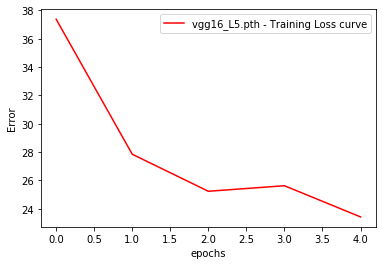

**********************  Valid  ******************************
Valid data batch sample


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


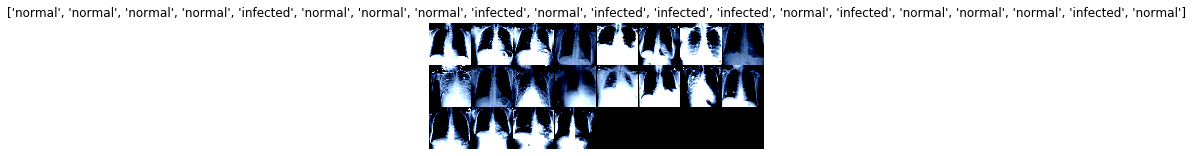

Predicted:  normal normal normal normal infected normal normal normal infected normal infected infected infected infected infected normal normal normal infected normal
Ground Truth:  normal normal normal normal infected normal normal normal infected normal infected infected infected normal infected normal normal normal infected normal
Valid matrix
[[575  40]
 [112 592]]
Accuracy of the network on the 10000 Valid images: 88 %
********************** END Valid  ******************************


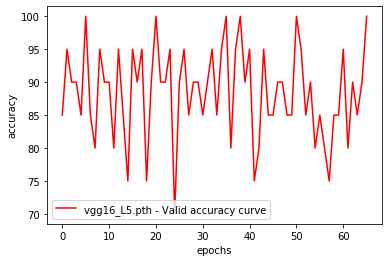

********************** END TRAINING  ******************************
**********************  test  ******************************
test data batch sample


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


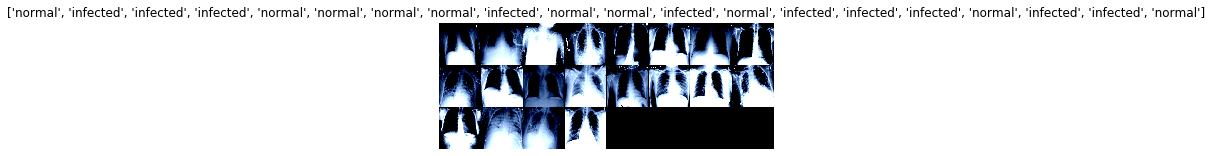

Predicted:  normal infected infected infected normal normal normal normal infected normal normal infected normal infected normal infected normal infected infected normal
Ground Truth:  normal infected infected infected normal normal normal normal infected normal normal infected normal infected infected infected normal infected infected normal
test matrix
[[585  30]
 [ 47 760]]
Accuracy of the network on the 10000 test images: 94 %
F1 Mearuser Value =  [0.9382518 0.9517846]
********************** END test  ******************************


In [5]:
vgg16_d = models.vgg16(pretrained=True)


Epochs = 5
criterion = nn.CrossEntropyLoss()
features = list()
model_name = "vgg16_L5.pth"

#############################  batch size  = 20        ##############################
batch_size = 20
#############################  Learning Rate  = 0.0008   ##############################
learning_rate = 0.0008
#############################  Freezed Layer  = 5       ##############################
freez_layers = 5

#data loaders
trainloader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, shuffle=True)
testloader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, shuffle=True)
validloader = torch.utils.data.DataLoader(valid_data, batch_size=batch_size, shuffle=True)

############################# Initializing Model ####################################
model = Trained_ClassifierModel(vgg16_d)

############################# Freezing Layer ########################################
model.freez_layers(freez_layers, 'vgg16')

#################### getting last layer input features ##############################
num_features = model.get_classifier_in_features('vgg16')

####################### Creating Classification Layers ##############################

# Adding Second Last layer whose no. of neurons will be (58 * 10) + 100 as my Rollno is MSDS 19058
features.extend([nn.Linear(num_features, 680 )])
# Adding last layer with 2 neurons as there 2 classes to classify
features.extend([nn.Linear(680, len(class_names))])
print (features)


####################### Replacing Classification Layers #############################
print ("before Replaces FCs", model.getModel())
model.replacelayers(features)
print ("before Replaces FCs", model.getModel())


####################### Checking Is Cuda available #################################
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

####################### Creating Optimizers #################################
optimizer = optim.SGD(model.getModel().parameters(), learning_rate, 0.9)

############################## Training Model ######################################
model.train(trainloader, validloader, optimizer, Epochs, criterion, device, model_name)


############################### Testing Model ######################################
model.test(testloader, device)


############################## Saving Model #######################################
pickle.dump(model.getModel, open('vgg16_FC_L5.pth', 'wb'))

#############################Clear Torch Cache ####################################
torch.cuda.empty_cache()


##### Task 2- VGG16 - Test 3

Layers freezed = NONE
[Linear(in_features=25088, out_features=680, bias=True), Linear(in_features=680, out_features=2, bias=True)]
before Replaces FCs VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 

Train Epoch: 0 [1106/1594 (99%)]	Loss: 0.836218: : 80it [03:49,  2.87s/it]


Training epoch 0 confusion matrix
[[564 188]
 [160 682]]


Train Epoch: 1 [1106/1594 (99%)]	Loss: 0.246393: : 80it [03:51,  2.90s/it]


Training epoch 1 confusion matrix
[[615 137]
 [122 720]]


Train Epoch: 2 [1106/1594 (99%)]	Loss: 0.336835: : 80it [03:54,  2.93s/it]


Training epoch 2 confusion matrix
[[633 119]
 [101 741]]


Train Epoch: 3 [1106/1594 (99%)]	Loss: 0.274833: : 80it [03:54,  2.93s/it]


Training epoch 3 confusion matrix
[[635 117]
 [ 88 754]]


Train Epoch: 4 [1106/1594 (99%)]	Loss: 0.635492: : 80it [03:56,  2.96s/it]


Training epoch 4 confusion matrix
[[650 102]
 [ 83 759]]


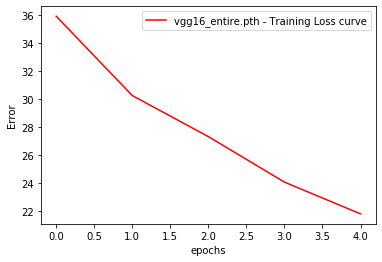

**********************  Valid  ******************************
Valid data batch sample


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


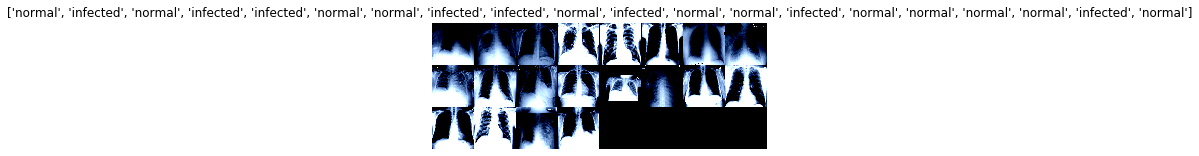

Predicted:  infected infected normal normal normal normal normal infected infected normal infected normal normal infected normal normal normal normal infected normal
Ground Truth:  normal infected normal infected infected normal normal infected infected normal infected normal normal infected normal normal normal normal infected normal
Valid matrix
[[455 160]
 [ 40 664]]
Accuracy of the network on the 10000 Valid images: 84 %
********************** END Valid  ******************************


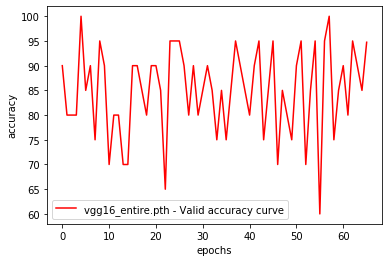

********************** END TRAINING  ******************************
**********************  test  ******************************
test data batch sample


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


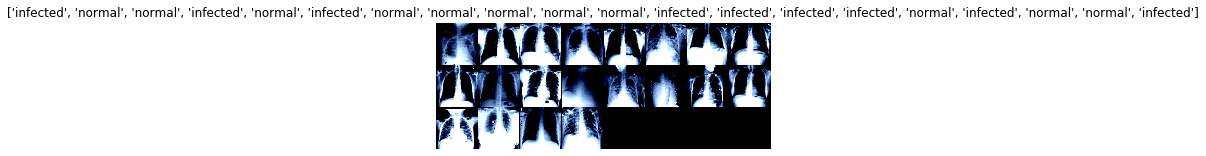

Predicted:  infected normal normal infected normal infected normal normal normal normal normal infected infected infected normal normal normal normal normal infected
Ground Truth:  infected normal normal infected normal infected normal normal normal normal normal infected infected infected infected normal infected normal normal infected
test matrix
[[514 101]
 [  7 800]]
Accuracy of the network on the 10000 test images: 92 %
F1 Mearuser Value =  [0.90492958 0.93676815]
********************** END test  ******************************


In [5]:
vgg16_d =  models.vgg16(pretrained=True)


Epochs = 5
criterion = nn.CrossEntropyLoss()
features = list()
model_name = "vgg16_entire.pth"

#############################  batch size  = 25        ##############################
batch_size = 25
#############################  Learning Rate  = 0.001   ##############################
learning_rate = 0.001
#############################  Freezed Layer  = none       ##############################
freez_layers = 'none'

#data loaders
trainloader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, shuffle=True)
testloader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, shuffle=True)
validloader = torch.utils.data.DataLoader(valid_data, batch_size=batch_size, shuffle=True)

############################# Initializing Model ####################################
model = Trained_ClassifierModel(vgg16_d)

############################# Freezing Layer ########################################
model.freez_layers(freez_layers,'vgg16')

#################### getting last layer input features ##############################
num_features = model.get_classifier_in_features('vgg16')

####################### Creating Classification Layers ##############################

# Adding Second Last layer whose no. of neurons will be (58 * 10) + 100 as my Rollno is MSDS 19058
features.extend([nn.Linear(num_features, 680 )])
# Adding last layer with 2 neurons as there 2 classes to classify
features.extend([nn.Linear(680, len(class_names))])
print (features)


####################### Replacing Classification Layers #############################
print ("before Replaces FCs", model.getModel())
model.replacelayers(features)
print ("before Replaces FCs", model.getModel())


####################### Checking Is Cuda available #################################
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

####################### Creating Optimizers #################################
optimizer = optim.SGD(model.getModel().parameters(), learning_rate, 0.9)

############################## Training Model ######################################
model.train(trainloader, validloader, optimizer, Epochs, criterion, device, model_name)

############################### Testing Model ######################################
model.test(testloader, device)


############################## Saving Model #######################################
pickle.dump(model.getModel, open(model_name, 'wb'))


#############################Clear Torch Cache ####################################
torch.cuda.empty_cache()

##### Task 2- Resnet18 - Test 1

Layers freezed =  4
[Linear(in_features=512, out_features=680, bias=True), Linear(in_features=680, out_features=2, bias=True)]
before Replaces FCs ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(

)
**********************  TRAINING  ******************************
running on GPU


Train Epoch: 0 [398/1594 (100%)]	Loss: 0.271852: : 200it [01:41,  1.97it/s]


Training epoch 0 confusion matrix
[[501 221   0 ...   0   2   0]
 [204 606   1 ...   1   0   1]
 [  0   0   0 ...   0   0   0]
 ...
 [  0   0   0 ...   0   0   0]
 [  0   0   0 ...   0   0   0]
 [  0   0   0 ...   0   0   0]]


Train Epoch: 1 [398/1594 (100%)]	Loss: 1.979126: : 200it [01:40,  1.99it/s]


Training epoch 1 confusion matrix
[[555 197]
 [171 671]]


Train Epoch: 2 [398/1594 (100%)]	Loss: 0.039334: : 200it [01:39,  2.01it/s]


Training epoch 2 confusion matrix
[[595 157]
 [141 701]]


Train Epoch: 3 [398/1594 (100%)]	Loss: 1.150371: : 200it [01:40,  1.99it/s]


Training epoch 3 confusion matrix
[[590 162]
 [163 679]]


Train Epoch: 4 [398/1594 (100%)]	Loss: 0.602717: : 200it [01:39,  2.01it/s]


Training epoch 4 confusion matrix
[[611 141]
 [137 705]]


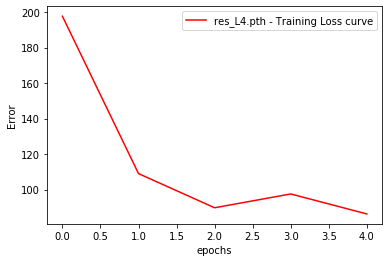

**********************  Valid  ******************************
Valid data batch sample


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


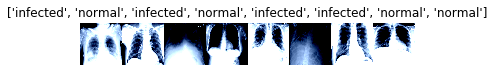

Predicted:  infected normal infected normal infected infected normal normal
Ground Truth:  infected normal infected normal infected infected normal normal
Valid matrix
[[513 102]
 [ 97 607]]
Accuracy of the network on the 10000 Valid images: 84 %
********************** END Valid  ******************************


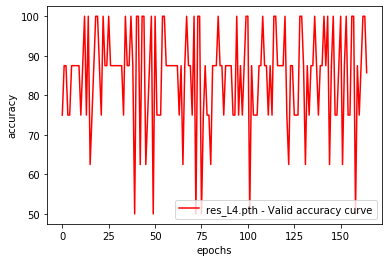

********************** END TRAINING  ******************************
**********************  test  ******************************
test data batch sample


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


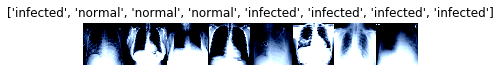

Predicted:  infected normal normal normal infected normal infected infected
Ground Truth:  infected normal normal normal infected infected infected infected
test matrix
[[559  56]
 [ 66 741]]
Accuracy of the network on the 10000 test images: 91 %
F1 Mearuser Value =  [0.9016129  0.92394015]
********************** END test  ******************************


In [5]:

resnet18_d =  models.resnet18(pretrained=True)


Epochs = 5
criterion = nn.CrossEntropyLoss()
features = list()
model_name = "res_L4.pth"

#############################  batch size  = 8        ##############################
batch_size = 8
#############################  Learning Rate  = 0.001   ##############################
learning_rate = 0.001
#############################  Freezed Layer  = 4       ##############################
freez_layers = 4

#data loaders
trainloader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, shuffle=True)
testloader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, shuffle=True)
validloader = torch.utils.data.DataLoader(valid_data, batch_size=batch_size, shuffle=True)

############################# Initializing Model ####################################
modelT2T1 = Trained_ClassifierModel(resnet18_d)

############################# Freezing Layer ########################################
modelT2T1.freez_layers(freez_layers,'resnet18')

#################### getting last layer input features ##############################
num_features = modelT2T1.get_classifier_in_features('resnet18')

####################### Creating Classification Layers ##############################

# Adding Second Last layer whose no. of neurons will be (58 * 10) + 100 as my Rollno is MSDS 19058
features.extend([nn.Linear(num_features, 680 )])
# Adding last layer with 2 neurons as there 2 classes to classify
features.extend([nn.Linear(680, len(class_names))])
print (features)


####################### Replacing Classification Layers #############################
print ("before Replaces FCs", modelT2T1.getModel())
modelT2T1.replacelayers(features)
print ("before Replaces FCs", modelT2T1.getModel())


####################### Checking Is Cuda available #################################
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

####################### Creating Optimizers #################################
optimizer = optim.SGD(modelT2T1.getModel().parameters(), learning_rate, 0.9)

############################## Training Model ######################################
modelT2T1.train(trainloader, validloader, optimizer, Epochs, criterion, device, model_name)



############################### Testing Model ######################################
modelT2T1.test(testloader, device)


############################## Saving Model #######################################
pickle.dump(modelT2T1.getModel, open(model_name, 'wb'))


#############################Clear Torch Cache ####################################
torch.cuda.empty_cache()


##### Task 2- Resnet18 - Test 2

Layers freezed =  5
[Linear(in_features=512, out_features=680, bias=True), Linear(in_features=680, out_features=2, bias=True)]
before Replaces FCs ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(

)
**********************  TRAINING  ******************************
running on GPU


Train Epoch: 0 [1106/1594 (99%)]	Loss: 0.795975: : 80it [01:29,  1.12s/it]


Training epoch 0 confusion matrix
[[493 172   0 ...   0   1   0]
 [147 609   1 ...   1   0   1]
 [  0   0   0 ...   0   0   0]
 ...
 [  0   0   0 ...   0   0   0]
 [  0   0   0 ...   0   0   0]
 [  0   0   0 ...   0   0   0]]


Train Epoch: 1 [1106/1594 (99%)]	Loss: 0.513517: : 80it [01:28,  1.11s/it]


Training epoch 1 confusion matrix
[[598 154]
 [146 696]]


Train Epoch: 2 [1106/1594 (99%)]	Loss: 0.289975: : 80it [01:29,  1.12s/it]


Training epoch 2 confusion matrix
[[609 143]
 [121 721]]


Train Epoch: 3 [1106/1594 (99%)]	Loss: 0.851628: : 80it [01:29,  1.12s/it]


Training epoch 3 confusion matrix
[[628 124]
 [109 733]]


Train Epoch: 4 [1106/1594 (99%)]	Loss: 0.275703: : 80it [01:29,  1.12s/it]


Training epoch 4 confusion matrix
[[637 115]
 [ 92 750]]


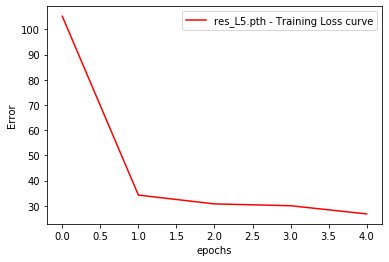

**********************  Valid  ******************************
Valid data batch sample


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


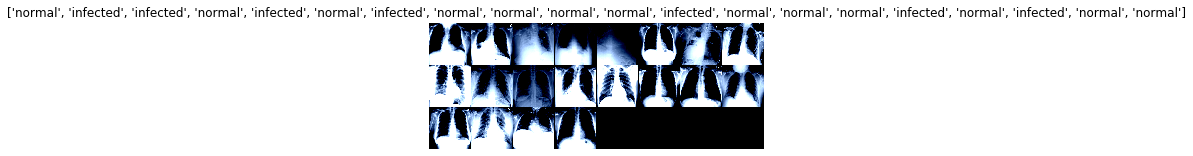

Predicted:  normal infected infected infected infected normal infected normal normal infected normal normal normal normal normal infected normal infected infected normal
Ground Truth:  normal infected infected normal infected normal infected normal normal normal normal infected normal normal normal infected normal infected normal normal
Valid matrix
[[577  38]
 [167 537]]
Accuracy of the network on the 10000 Valid images: 84 %
********************** END Valid  ******************************


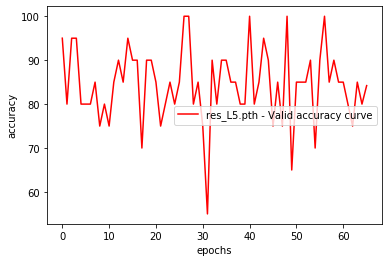

********************** END TRAINING  ******************************
**********************  test  ******************************
test data batch sample


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


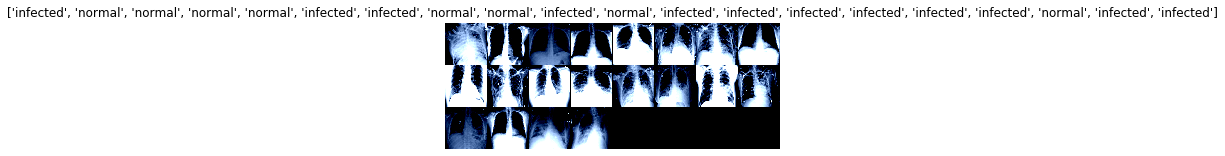

Predicted:  infected normal normal normal normal infected infected normal normal infected normal infected infected infected infected infected infected normal infected infected
Ground Truth:  infected normal normal normal normal infected infected normal normal infected normal infected infected infected infected infected infected normal infected infected
test matrix
[[589  26]
 [130 677]]
Accuracy of the network on the 10000 test images: 89 %
F1 Mearuser Value =  [0.88305847 0.89668874]
********************** END test  ******************************


In [5]:

resnet18_d = models.resnet18(pretrained=True)

Epochs = 5
criterion = nn.CrossEntropyLoss()
features = list()
model_name = "res_L5.pth"

#############################  batch size  = 20        ##############################
batch_size = 20
#############################  Learning Rate  = 0.0008   ##############################
learning_rate = 0.0008
#############################  Freezed Layer  = 5       ##############################
freez_layers = 5

#data loaders
trainloader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, shuffle=True)
testloader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, shuffle=True)
validloader = torch.utils.data.DataLoader(valid_data, batch_size=batch_size, shuffle=True)

############################# Initializing Model ####################################
model = Trained_ClassifierModel(resnet18_d)

############################# Freezing Layer ########################################
model.freez_layers(freez_layers,'resnet18')

#################### getting last layer input features ##############################
num_features = model.get_classifier_in_features('resnet18')

####################### Creating Classification Layers ##############################

# Adding Second Last layer whose no. of neurons will be (58 * 10) + 100 as my Rollno is MSDS 19058
features.extend([nn.Linear(num_features, 680 )])
# Adding last layer with 2 neurons as there 2 classes to classify
features.extend([nn.Linear(680, len(class_names))])
print (features)


####################### Replacing Classification Layers #############################
print ("before Replaces FCs", model.getModel())
model.replacelayers(features)
print ("before Replaces FCs", model.getModel())


####################### Checking Is Cuda available #################################
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

####################### Creating Optimizers #################################
optimizer = optim.SGD(model.getModel().parameters(), learning_rate, 0.9)

############################## Training Model ######################################
model.train(trainloader, validloader, optimizer, Epochs, criterion, device, model_name)


############################### Testing Model ######################################
model.test(testloader, device)


############################## Saving Model #######################################
pickle.dump(model.getModel, open(model_name, 'wb'))


#############################Clear Torch Cache ####################################
torch.cuda.empty_cache()


##### Task 2- Resnet18 - Test 3

Layers freezed = NONE
[Linear(in_features=512, out_features=680, bias=True), Linear(in_features=680, out_features=2, bias=True)]
before Replaces FCs ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding

)
**********************  TRAINING  ******************************
running on GPU


Train Epoch: 0 [1197/1594 (98%)]	Loss: 0.484020: : 64it [01:30,  1.41s/it]


Training epoch 0 confusion matrix
[[505 158   1 ...   0   0   0]
 [132 612   0 ...   2   1   1]
 [  0   0   0 ...   0   0   0]
 ...
 [  0   0   0 ...   0   0   0]
 [  0   0   0 ...   0   0   0]
 [  0   0   0 ...   0   0   0]]


Train Epoch: 1 [1197/1594 (98%)]	Loss: 0.206117: : 64it [01:26,  1.35s/it]


Training epoch 1 confusion matrix
[[605 147]
 [137 705]]


Train Epoch: 2 [1197/1594 (98%)]	Loss: 0.307724: : 64it [01:26,  1.35s/it]


Training epoch 2 confusion matrix
[[627 125]
 [111 731]]


Train Epoch: 3 [1197/1594 (98%)]	Loss: 0.594064: : 64it [01:27,  1.36s/it]


Training epoch 3 confusion matrix
[[630 122]
 [106 736]]


Train Epoch: 4 [1197/1594 (98%)]	Loss: 0.388370: : 64it [01:26,  1.35s/it]


Training epoch 4 confusion matrix
[[642 110]
 [103 739]]


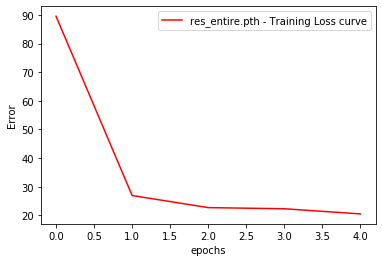

**********************  Valid  ******************************
Valid data batch sample


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


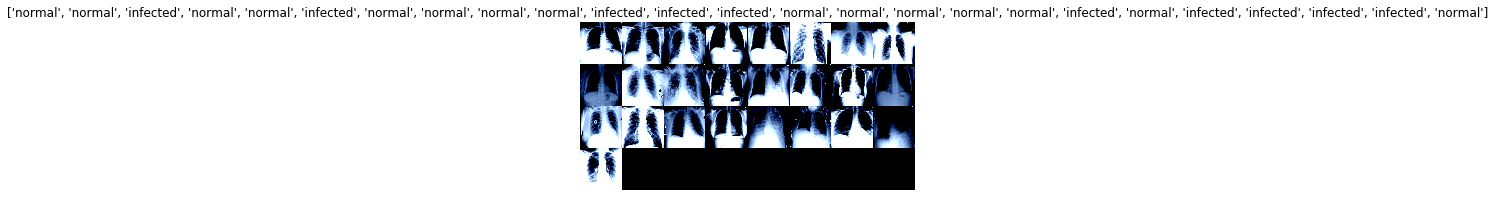

Predicted:  normal normal infected normal normal infected infected normal normal normal infected infected normal infected normal normal infected normal infected normal infected infected normal infected normal
Ground Truth:  normal normal infected normal normal infected normal normal normal normal infected infected infected normal normal normal normal normal infected normal infected infected infected infected normal
Valid matrix
[[500 115]
 [ 72 632]]
Accuracy of the network on the 10000 Valid images: 85 %
********************** END Valid  ******************************


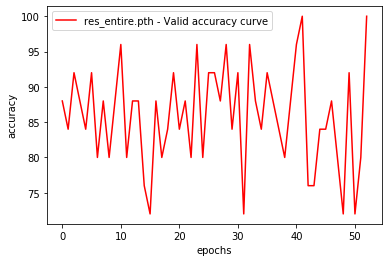

********************** END TRAINING  ******************************
**********************  test  ******************************
test data batch sample


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


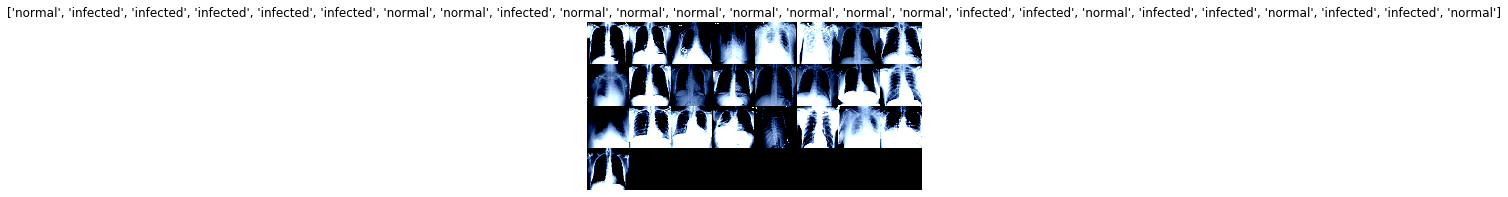

Predicted:  normal infected infected infected infected infected normal normal infected normal normal normal normal normal normal normal infected normal normal infected infected normal infected infected normal
Ground Truth:  normal infected infected infected infected infected normal normal infected normal normal normal normal normal normal normal infected infected normal infected infected normal infected infected normal
test matrix
[[557  58]
 [ 34 773]]
Accuracy of the network on the 10000 test images: 93 %
F1 Mearuser Value =  [0.92371476 0.94383394]
********************** END test  ******************************


In [6]:

resnet18_d = models.resnet18(pretrained=True)

Epochs = 5

criterion = nn.CrossEntropyLoss()
features = list()
model_name = "res_entire.pth"

#############################  batch size  = 25        ##############################
batch_size = 25
#############################  Learning Rate  = 0.001   ##############################
learning_rate = 0.001
#############################  Freezed Layer  = none       ##############################
freez_layers = 'none'

#data loaders
trainloader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, shuffle=True)
testloader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, shuffle=True)
validloader = torch.utils.data.DataLoader(valid_data, batch_size=batch_size, shuffle=True)

############################# Initializing Model ####################################
model = Trained_ClassifierModel(resnet18_d)

############################# Freezing Layer ########################################
model.freez_layers(freez_layers,'resnet18')

#################### getting last layer input features ##############################
num_features = model.get_classifier_in_features('resnet18')

####################### Creating Classification Layers ##############################

# Adding Second Last layer whose no. of neurons will be (58 * 10) + 100 as my Rollno is MSDS 19058
features.extend([nn.Linear(num_features, 680 )])
# Adding last layer with 2 neurons as there 2 classes to classify
features.extend([nn.Linear(680, len(class_names))])
print (features)


####################### Replacing Classification Layers #############################
print ("before Replaces FCs", model.getModel())
model.replacelayers(features)
print ("before Replaces FCs", model.getModel())


####################### Checking Is Cuda available #################################
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

####################### Creating Optimizers #################################
optimizer = optim.SGD(model.getModel().parameters(), learning_rate, 0.9)

############################## Training Model ######################################
model.train(trainloader, validloader, optimizer, Epochs, criterion, device, model_name)


############################### Testing Model ######################################
model.test(testloader, device)


############################## Saving Model #######################################
# pickle.dump(model.getModel, open(model_name, 'wb'))

#############################Clear Torch Cache ####################################
torch.cuda.empty_cache()
